# Распознавание лиц

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Датасет

Я взял часть открытого датасета [celebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). В нем лежит ~24 000 выровненных фотографий 500 людей
- в `celebA_imgs` лежат сами картинки
- в `celebA_anno.txt` каждой картинке сопоставлен ее id
- в `celebA_train_split.txt` лежит разбиение датасета на train/val/test. Разбито в соотношении 0.71/0.16/0.13 со стратификацией


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!unzip -q gdrive/MyDrive/celebA_train_500.zip

replace celebA_train_500/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [22]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [23]:
anno = {}
with open('celebA_train_500/celebA_anno.txt') as file:
    for line in file:
        key, value = line.split()
        anno[key] = int(value)

In [24]:
split = {}
with open('celebA_train_500/celebA_train_split.txt') as file:
    for line in file:
        key, value = line.split()
        split[key] = int(value)

In [25]:
train_labels = {}
val_labels = {}
test_labels = {}

root = 'celebA_train_500/celebA_imgs'
files = list(os.walk(os.path.join(root)))[0][2]

for file in files:
    if file in anno:
        if split[file] == 0:
            train_labels[file] = anno[file]
        if split[file] == 1:
            val_labels[file] = anno[file]
        if split[file] == 2:
            test_labels[file] = anno[file]

In [26]:
train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels   = pd.DataFrame(list(  val_labels.items()), columns = ['img', 'label'])
test_labels  = pd.DataFrame(list( test_labels.items()), columns = ['img', 'label'])
test_labels.head()

,img,label
0,157595.jpg,139
1,139105.jpg,134
2,161347.jpg,126
3,119392.jpg,380
4,129696.jpg,471


In [27]:
class FaceDataset(Dataset):
    def __init__(self, labels, img_dir, transform):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        img_label = int(self.img_labels.iloc[idx, 1])
        return img, img_label

    def __len__(self):
        return len(self.img_labels)

In [28]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(180),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
train_dataset = FaceDataset(train_labels, root, data_transform)
val_dataset   = FaceDataset(val_labels,   root, data_transform)
test_dataset  = FaceDataset(test_labels,  root, data_transform)

In [30]:
def plot_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    plt.imshow(img)
    plt.axis('off')

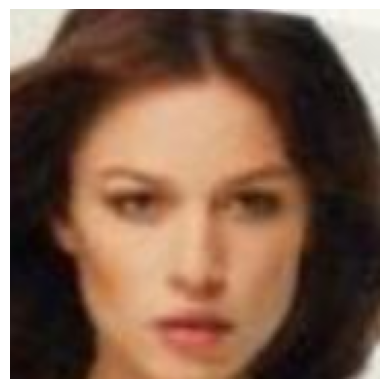

In [31]:
plot_img(test_dataset[0][0])

In [32]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)
loaders = {'train': train_loader, 'valid': val_loader}

## Модель

In [33]:
model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
n_classes = 500
model.fc = nn.Linear(model.fc.in_features, n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
frozen_layers = 1

for i, layer in enumerate(model.children()):
    if i < frozen_layers:
        for param in layer.parameters():
            param.requires_grad = False

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

In [37]:
def train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs):
    loss_history = {'train': [], 'valid': []}
    acc_history = {'train': [], 'valid': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')

        for stage, loader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            train_loss = 0
            val_loss = 0

            for x_batch, y_batch in loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if stage == 'train':
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        output = model(x_batch)
                        val_loss = criterion(output, y_batch)

                preds = output.argmax(-1)
                correct = torch.sum(y_batch == preds)
                epoch_correct += correct.item()
                epoch_all += len(y_batch)

                if stage == 'train':
                    train_loss = criterion(output, y_batch)
                    train_loss.backward()
                    optimizer.step()

            loss_epoch = train_loss.item() if stage == 'train' else val_loss.item()
            acc_epoch = epoch_correct / epoch_all
            loss_history[stage].append(loss_epoch)
            acc_history[stage].append(acc_epoch)
            print(f'{stage} loss = {"%.5f" % loss_epoch}, accuracy = {"%.5f" % acc_epoch}')

        scheduler.step()

    return np.arange(num_epochs), loss_history, acc_history

In [38]:
num_epochs = 10
epochs, loss, acc = train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs)

Epoch 1
train loss = 4.27228, accuracy = 0.06636
valid loss = 4.19963, accuracy = 0.12726
Epoch 2
train loss = 2.63307, accuracy = 0.30688
valid loss = 3.17880, accuracy = 0.28647
Epoch 3
train loss = 1.57323, accuracy = 0.61891
valid loss = 2.22914, accuracy = 0.43610
Epoch 4
train loss = 0.77601, accuracy = 0.84176
valid loss = 1.61458, accuracy = 0.56177
Epoch 5
train loss = 0.25884, accuracy = 0.97203
valid loss = 0.88222, accuracy = 0.68743
Epoch 6
train loss = 0.09800, accuracy = 0.99824
valid loss = 0.64938, accuracy = 0.72684
Epoch 7
train loss = 0.02768, accuracy = 0.99965
valid loss = 0.62525, accuracy = 0.75453
Epoch 8
train loss = 0.02042, accuracy = 0.99953
valid loss = 0.59946, accuracy = 0.75346
Epoch 9
train loss = 0.01434, accuracy = 1.00000
valid loss = 0.57334, accuracy = 0.75346
Epoch 10
train loss = 0.01493, accuracy = 1.00000
valid loss = 0.57756, accuracy = 0.75453


In [39]:
def plot_history(epochs, loss, acc):
    fig, ax = plt.subplots(1, 2)

    ax[0].plot(epochs, loss['train'], label='train')
    ax[0].plot(epochs, loss['valid'], label='valid')
    ax[0].set_title('loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(epochs, acc['train'], label='train')
    ax[1].plot(epochs, acc['valid'], label='valid')
    ax[1].set_title('accuracy')
    ax[1].grid()
    ax[1].legend()

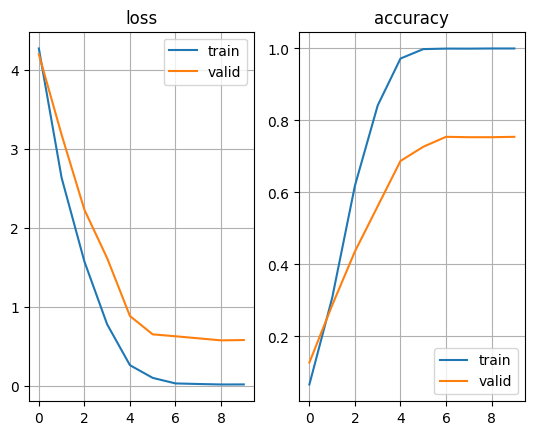

In [40]:
plot_history(epochs, loss, acc)

In [43]:
def calculate_accuracy(model, loader):
    all = 0
    correct = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        model.eval()
        output = model(x_batch)
        preds = output.argmax(-1)
        correct += torch.sum(y_batch == preds)
        all += len(y_batch)

    return correct / all

In [44]:
print(f'test accuracy = {calculate_accuracy(model, test_loader)}')

test accuracy = 0.7426053881645203
